# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Load data

In [2]:
iris = datasets.load_iris()

In [3]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
target_labels = iris.target_names
target_labels

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
target_labels_dic = {
    0: 'setosa',
    1: 'versicolor',
    2: 'virginica'
}

In [6]:
X = pd.DataFrame(iris.data)
X.columns = iris.feature_names
X = X[X.columns[2:]] # Selecting two columns
X.head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


In [7]:
y = pd.DataFrame(iris.target)
y.columns = ['target']
y.head()

,target
0,0
1,0
2,0
3,0
4,0


In [8]:
# I'll make it a binary classification problem so I can use ROC-AUC
y = y[y.target!=0]
X = X[X.index.isin(y.index)]
target_labels = iris.target_names[1:]
target_labels

array(['versicolor', 'virginica'], dtype='<U10')

# EDA

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 50 to 149
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   petal length (cm)  100 non-null    float64
 1   petal width (cm)   100 non-null    float64
dtypes: float64(2)
memory usage: 2.3 KB


In [10]:
X.describe()

,petal length (cm),petal width (cm)
count,100.000000,100.000000
mean,4.906000,1.676000
std,0.825578,0.424769
min,3.000000,1.000000
25%,4.375000,1.300000
50%,4.900000,1.600000
75%,5.525000,2.000000
max,6.900000,2.500000


In [11]:
X.isna().sum()

petal length (cm)    0
petal width (cm)     0
dtype: int64

In [12]:
X.corr()

,petal length (cm),petal width (cm)
petal length (cm),1.000000,0.823348
petal width (cm),0.823348,1.000000


In [13]:
y.value_counts()

target
1         50
2         50
Name: count, dtype: int64

# Split dataset into train/test

## **ALWAYS** before feature engineering and modeling

The primary reason for performing a train/test split before feature engineering and modeling is to prevent data leakage and to ensure that the evaluation of your model is accurate and indicative of its performance on unseen data.

- Prevention of Data Leakage
- Accurate Evaluation
- Ethical Modeling Practices

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering

### Feature scaling

- For distance-based algortihms like KNN it's important to scale features because otherwise the calculation will be dominated by features with larger scales.
  - For instance, consider a dataset with two features: one feature ranges between 0 and 1, and another ranges between 0 and 1000. The larger feature would disproportionately influence the distance calculation, potentially leading to incorrect classifications or predictions.
- It's crucial to **fit the scaler on your training data** and not the entire dataset. This is to avoid data leakage.
- If you were to fit the scaler on the entire dataset, it would calculate scaling parameters (like the mean and standard deviation for standardization) that reflect the distribution of the entire dataset, test set included.
- Once the scaler is **fitted on the training set**, it can then be used to **transform the training set, as well as the validation and test sets**. This means the test data is scaled according to the statistics of the training data, which mirrors the real-life scenario where we apply the model to unseen data.



In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(X_train)

StandardScaler()

In [17]:
scaler.mean_

array([4.95875, 1.71125])

In [18]:
scaler.var_

array([0.70692344, 0.17899844])

In [19]:
scaler.get_feature_names_out()

array(['petal length (cm)', 'petal width (cm)'], dtype=object)

In [20]:
X_train = pd.DataFrame(scaler.transform(X_train))
X_train

,0,1
0,1.952039,0.918852
1,-0.188811,0.209770
2,-0.188811,-0.735673
3,-1.140300,-1.208394
4,0.049061,-0.499312
...,...,...
75,0.167997,0.682492
76,-0.069875,0.682492
77,-1.616045,-0.972034
78,0.167997,0.446131


# Modeling

### Selecting the best $k$, number of neighbors

In [21]:
# Trying different values for n_neighbors
neighbors = range(1, 21)
cv_scores = []

In [22]:
for k in neighbors:
    print(f"Calculating for k={k}")
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

Calculating for k=1
Calculating for k=2
Calculating for k=3
Calculating for k=4
Calculating for k=5
Calculating for k=6
Calculating for k=7
Calculating for k=8
Calculating for k=9
Calculating for k=10
Calculating for k=11
Calculating for k=12
Calculating for k=13
Calculating for k=14
Calculating for k=15
Calculating for k=16
Calculating for k=17
Calculating for k=18
Calculating for k=19
Calculating for k=20


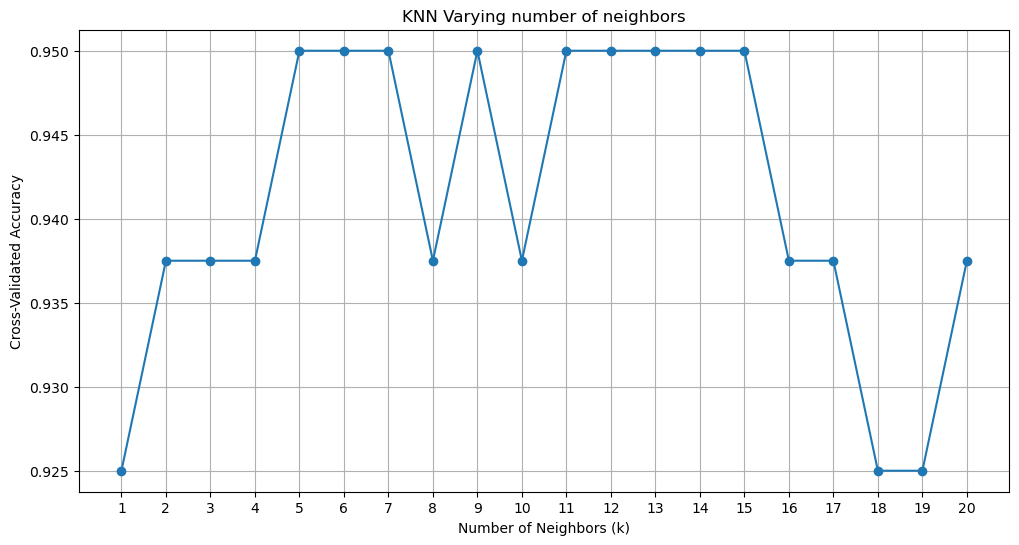

In [23]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(neighbors, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Varying number of neighbors')
plt.xticks(range(1, 21))
plt.grid()
plt.show()

### Now we retrain the model on the entire training set for $k=5$

In [24]:
# Initialize the KNN model with k=5
knn_optimal = KNeighborsClassifier(n_neighbors=5)

In [25]:
# Retrain the model on the entire training dataset
knn_optimal.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

# Model evaluation

Don't forget to transform your `X_test` the same way you did with `X_train`

In [26]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled.head()

,0,1
0,0.167997,-0.499312
1,0.762678,0.209770
2,0.881614,1.391574
3,-0.902428,-1.208394
4,-0.902428,-0.972034


In [27]:
# Make predictions on the test set
y_pred = knn_optimal.predict(X_test_scaled)

In [28]:
y_pred

array([1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1])

In [29]:
knn_optimal.predict_proba(X_test_scaled)

array([[0.8, 0.2],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [0.6, 0.4],
       [0. , 1. ],
       [1. , 0. ],
       [0.4, 0.6],
       [0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ]])

In [30]:
# Naming the labels
y_test_named = [target_labels_dic[i[0]] for i in y_test.values]
y_pred_named = [target_labels_dic[i] for i in y_pred]

In [31]:
print(classification_report(y_test_named, y_pred_named))

              precision    recall  f1-score   support

  versicolor       0.92      1.00      0.96        12
   virginica       1.00      0.88      0.93         8

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



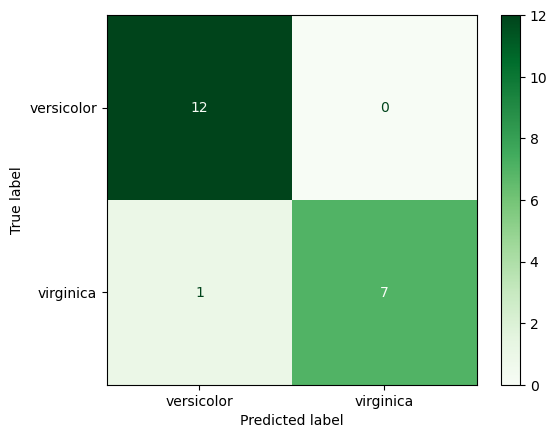

In [32]:
cm = confusion_matrix(y_true=y_test_named, y_pred=y_pred_named, labels=target_labels)
ConfusionMatrixDisplay(cm, display_labels=target_labels).plot(cmap=plt.cm.Greens)
plt.show()

### A few notes about `roc_auc_score`

- You can use this with a multiclass dataset the following way
`roc_auc_score(y_test.values.ravel(), knn_optimal.predict_proba(X_test_scaled), multiclass='ovr') `
  - OvR (One-vs-Rest). You'll N different binary classifiers  
  - OvO (One-vs-One). You'll have all possible convos of classifiers

- For binary classification, you use `knn_optimal.predict_proba(X_test_scaled)[:, 1]` to get probabilities for the positive class


In [33]:
r_a_score = roc_auc_score(y_test.values.ravel(), knn_optimal.predict_proba(X_test_scaled)[:, 1], multi_class='raise')
print(f"ROC AUC Score: {r_a_score}")

ROC AUC Score: 0.984375


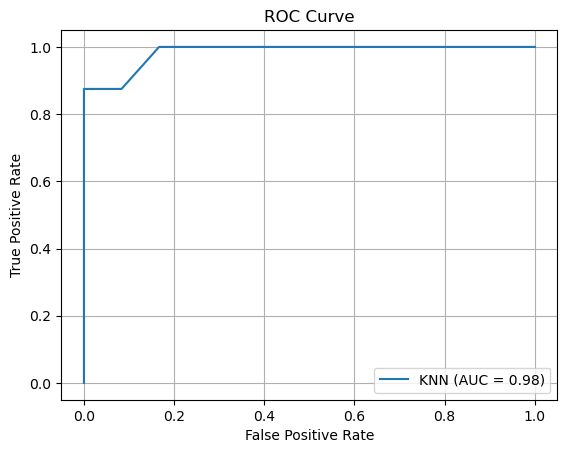

In [34]:
# Plotting ROC curve
y_probs = knn_optimal.predict_proba(X_test_scaled)[:, 1]

# Compute TPR, FPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_named, y_probs, pos_label='virginica')

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Create ROC Curve Display
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN')

# Plot the ROC Curve
roc_display.plot()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [35]:
thresholds

array([inf, 1. , 0.6, 0.4, 0.2, 0. ])

In [36]:
# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Find the smallest distance
min_distance_idx = np.argmin(distances)

# Find the optimal threshold
optimal_threshold = thresholds[min_distance_idx]
op_fpr = fpr[min_distance_idx]
op_tpr = tpr[min_distance_idx]

In [37]:
optimal_threshold, op_fpr, op_tpr

(0.6, 0.0, 0.875)

In [38]:
final_predictions = (y_probs >= optimal_threshold).astype(int)
final_predictions_named = [target_labels_dic[i+1] for i in final_predictions]
final_predictions_named

['versicolor',
 'virginica',
 'virginica',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'virginica',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'virginica',
 'versicolor',
 'virginica',
 'versicolor',
 'virginica',
 'virginica',
 'versicolor',
 'versicolor']

# Interpretation

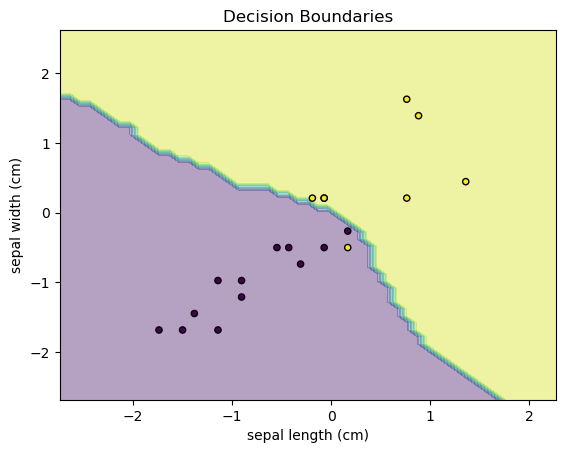

In [39]:
# Create a mesh grid for plotting
x_min, x_max = X_test_scaled.iloc[:, 0].min() - 1, X_test_scaled.iloc[:, 0].max() + 1
y_min, y_max = X_test_scaled.iloc[:, 1].min() - 1, X_test_scaled.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = knn_optimal.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test_scaled.iloc[:, 0], X_test_scaled.iloc[:, 1], c=y_test.values.ravel(), s=20, edgecolor='k')
plt.title('Decision Boundaries')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

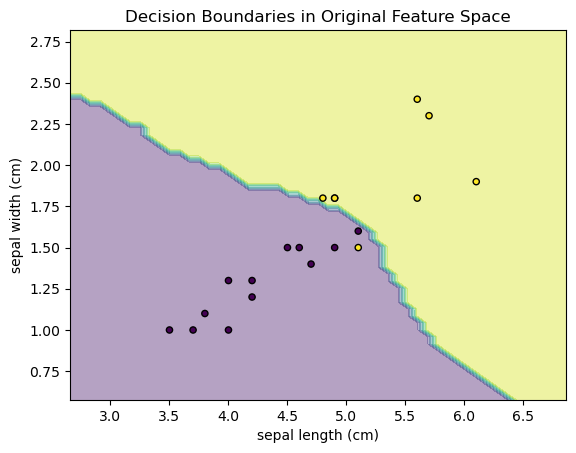

In [40]:
# Create a mesh grid for plotting in the scaled space
x_min, x_max = X_test_scaled.iloc[:, 0].min() - 1, X_test_scaled.iloc[:, 0].max() + 1
y_min, y_max = X_test_scaled.iloc[:, 1].min() - 1, X_test_scaled.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = knn_optimal.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Inverse transform the mesh grid points back to the original scale
xx_inv, yy_inv = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()]).T
xx_inv = xx_inv.reshape(xx.shape)
yy_inv = yy_inv.reshape(yy.shape)

# Plotting the decision boundaries in the original feature space
plt.contourf(xx_inv, yy_inv, Z, alpha=0.4)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test.values.ravel(), s=20, edgecolor='k')
plt.title('Decision Boundaries in Original Feature Space')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [41]:
##TODO: Double-check it's plotting correctly
# Determine the limits of the plot from the full dataset
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid with the KNN model
Z = knn_optimal.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundary using a contour plot
contour = go.Contour(
    x=np.arange(x_min, x_max, 0.1),
    y=np.arange(y_min, y_max, 0.1),
    z=Z,
    contours_coloring='lines',
    showscale=False
)

# Inverse transform the training and test datasets to plot in original feature space
X_train_inv = scaler.inverse_transform(X_train)
X_test_inv = scaler.inverse_transform(X_test_scaled)

# Create hover text for the training data
train_hover_text = ['Train: {}'.format(target_labels_dic[true])
                    for true in y_train.values.ravel()]

# Create hover text for the test data
test_hover_text = ['Test - True: {}, Pred: {}'.format(true, pred)
                   for true, pred in zip(y_test_named, final_predictions_named)]

# Scatter plot for the training data
scatter_train = go.Scatter(
    x=X_train_inv[:, 0],
    y=X_train_inv[:, 1],
    mode='markers',
    marker=dict(color='gray', size=10, opacity=0.5),
    name='Training Data',
    text=train_hover_text,
    hoverinfo='text'
)

# Scatter plot for the test data colored by predictions
scatter_test = go.Scatter(
    x=X_test_inv[:, 0],
    y=X_test_inv[:, 1],
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.5,
        color=final_predictions,  # Use the predicted labels to define the color
        colorscale='Viridis',  # This is a sequential colorscale, you can choose any other
        colorbar=dict(title='Predicted Class'),
        line=dict(color='black', width=1)
    ),
    name='Test Data',
    text=test_hover_text,
    hoverinfo='text'
)

# Combine all plots
fig = go.Figure(data=[contour, scatter_train, scatter_test])

# Update the layout
fig.update_layout(
    title='Decision Boundary with Training and Test Data',
    xaxis_title='sepal length (cm)',
    yaxis_title='sepal width (cm)',
)

# Show the plot
fig.show()

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Deployment

In [42]:
# TODO: Adjust functions for optimal threshold. Also write ideas about deployment using Flask/Cloud

import joblib

# Save the model
joblib.dump(knn_optimal, 'knn_model.pkl')

# If you also need to save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [43]:
# Predict on new data

def load_model(model_path):
    return joblib.load(model_path)

def predict(input_features, model, scaler):
    # Scale the features using the loaded scaler
    scaled_features = scaler.transform([input_features])
    # Predict with the KNN model
    return model.predict(scaled_features)

In [45]:
# Usage
model = load_model('knn_model.pkl')
scaler = load_model('scaler.pkl')
new_data = [4.6, 3.2]  # Example new data
prediction = predict(new_data, model, scaler)
print(target_labels_dic[prediction[0]])

virginica


c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

